In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import gc
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv2D, Reshape, Dropout, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.activations import relu, elu, linear
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18

2.0.0


# Fashion MNIST - Convolutional Neural Network
## Loading Data

In [2]:
X_train = np.load("../data/X_train.npy")
X_test = np.load("../data/X_test.npy")
X_val = np.load("../data/X_val.npy")
Y_train = np.load("../data/Y_train.npy")
Y_test = np.load("../data/Y_test.npy")
Y_val = np.load("../data/Y_val.npy")
Y_onehot_train = np_utils.to_categorical(Y_train)
Y_onehot_test = np_utils.to_categorical(Y_test)
Y_onehot_val = np_utils.to_categorical(Y_val)
X_train_reshaped = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], 28, 28, 1))

nr_params = X_train.shape[1]

## Setting up general CNN model

In [3]:
def make_conv_model(params):
    opti = optimizers.Adam(amsgrad=True, lr=params["lr"])
    def nn_clf():
        model = Sequential()
        model.add(Conv2D(filters = params["nr_neurons"], kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
        model.add(Dropout(params["dropout"]))
        for i in range(params["nr_layers"] - 1):
            model.add(Conv2D(filters = params["nr_neurons"], kernel_size = (5,5), padding = 'Same', activation ='relu'))
            model.add(Dropout(params["dropout"]))
        model.add(MaxPool2D(pool_size=(2,2)))
        for i in range(params["nr_layers"]):
            model.add(Conv2D(filters = 2*params["nr_neurons"], kernel_size = (3,3), padding = 'Same', activation ='relu'))
            model.add(Dropout(params["dropout"]))
        model.add(MaxPool2D(pool_size=(2,2)))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(params["dropout"]))
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(params["dropout"]))
        model.add(Dense(10, activation = "softmax"))
        model.compile(optimizer=opti, loss="categorical_crossentropy",  metrics=["accuracy"])
        return model
    return nn_clf

## Performing a test run

In [47]:
params = {
    "lr" : 1e-3,
    "batch_size" : 256,
    "nr_neurons": 32,
    "nr_layers" : 2,
    "dropout" : 0.2
}

In [48]:
make_conv_model(params)().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 64)       

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
clf = KerasClassifier(build_fn=make_conv_model(params), batch_size=params["batch_size"], epochs=200, validation_data=(X_test_reshaped, Y_onehot_test), callbacks=callbacks, verbose=1)
history = clf.fit(X_train_reshaped, Y_onehot_train)
Y_pred = clf.predict(X_val_reshaped)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history["val_accuracy"], c="crimson")
plt.plot(history.history["accuracy"], c="navy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Hyperparameter Optimization
## Learning Rate vs Batch Size

In [96]:
all_params = {
    "batch_size" : [8, 64, 256, 1024],
    "lr" : [1e-2, 1e-3, 1e-4],
}
nr_runs = len(all_params['batch_size'])*len(all_params["lr"])

In [ ]:
hp_dict = {
    "acc_score" : [],
    "batch_size" : [],
    "lr" : []
}

k = 0
t0 = time.time()
for batch_size in all_params["batch_size"]:
    for lr in all_params["lr"]:
        params = {
            "batch_size" : batch_size,
            "lr" : lr,
            "nr_layers" : 2,
            "nr_neurons" : 32,
            "dropout" : 0.2,
             }

        hp_dict["batch_size"].append(batch_size)
        hp_dict["lr"].append(lr)

        callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
        model = make_conv_model(params)
        clf = KerasClassifier(build_fn=model, batch_size=params["batch_size"], epochs=200, validation_data=(X_test_reshaped, Y_onehot_test), callbacks=callbacks, verbose=1)
        history = clf.fit(X_train_reshaped, Y_onehot_train)
        Y_pred = clf.predict(X_val_reshaped)
        del history, clf, model
        gc.collect()
        K.clear_session()
        hp_dict["acc_score"].append(accuracy_score(Y_val, Y_pred))

        k += 1
        print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")

In [98]:
#hp_df = pd.DataFrame.from_dict(hp_dict)
#hp_df.to_pickle("../data/hp_df_CNN_lr_batch.pickle")
hp_df = pd.read_pickle("../data/hp_df_CNN_lr_batch.pickle")

In [99]:
hp_df

,acc_score,batch_size,lr
0,0.1028,8,0.0100
1,0.9229,8,0.0010
2,0.9309,8,0.0001
3,0.0965,64,0.0100
4,0.9333,64,0.0010
5,0.9309,64,0.0001
6,0.0946,256,0.0100
7,0.9350,256,0.0010
8,0.9283,256,0.0001
9,0.9089,1024,0.0100


In [100]:
hp_matrix = np.zeros((4, 3))
for i in range(4):
    for j in range(3):
        hp_matrix[i,j] = hp_df["acc_score"].iloc[j+i*3]

0.935

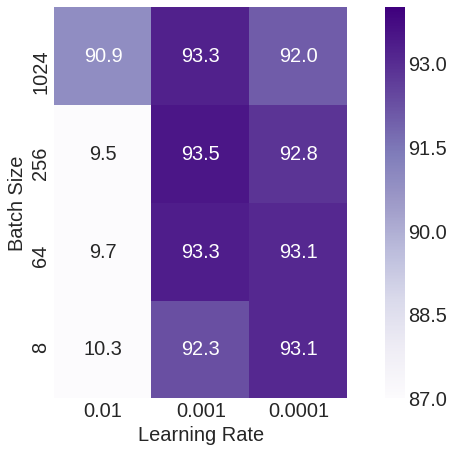

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(100*hp_matrix, ax=ax, annot=True, fmt=".1f", vmin=87, vmax=94, square=True, xticklabels=all_params["lr"], yticklabels=all_params["batch_size"], cmap="Purples")
plt.ylim(0, 4);
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size");
plt.tight_layout()
plt.savefig("../figs/CNN_lr_batchsize_heatmap.pdf", bbox_inches="tight");
hp_matrix.max()

## Network Size and Depth, and Dropout Rate

In [71]:
all_params = {
    "nr_layers" : [1, 2, 3],
    "nr_neurons" : [16, 32, 64],
    "dropout" : [0, 0.2]
}
nr_runs = len(all_params['nr_layers'])*len(all_params["nr_neurons"])

In [ ]:
hp_dict = {
    "acc_score" : [],
    "nr_layers" : [],
    "nr_neurons" : [],
    "dropout" : []
}

k = 0
t0 = time.time()
for nr_layers in all_params["nr_layers"]:
    for nr_neurons in all_params["nr_neurons"]:
        for dropout in all_params["dropout"]:
            params = {
                "batch_size" : 256,
                "lr" : 1e-3,
                "nr_layers" : nr_layers,
                "nr_neurons" : nr_neurons,
                "dropout" : dropout
                 }

            hp_dict["nr_layers"].append(nr_layers)
            hp_dict["nr_neurons"].append(nr_neurons)
            hp_dict["dropout"].append(dropout)

            callbacks = [EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)]
            model = make_conv_model(params)
            clf = KerasClassifier(build_fn=model, batch_size=params["batch_size"], epochs=200, validation_data=(X_test_reshaped, Y_onehot_test), callbacks=callbacks, verbose=1)
            history = clf.fit(X_train_reshaped, Y_onehot_train)
            Y_pred = clf.predict(X_val_reshaped)
            del history, clf, model
            gc.collect()
            K.clear_session()
            hp_dict["acc_score"].append(accuracy_score(Y_val, Y_pred))

            k += 1
            print(f"{100*k/nr_runs:.1f} %, {(time.time()-t0)/60:.1f} m")

In [72]:
#hp_df = pd.DataFrame.from_dict(hp_dict)
#hp_df.to_pickle("../data/hp_df_CNN_network_size.pickle")
hp_df = pd.read_pickle("../data/hp_df_CNN_network_size.pickle")

In [73]:
hp_df

,acc_score,nr_layers,nr_neurons,dropout
0,0.9196,1,16,0.0
1,0.9265,1,16,0.2
2,0.9265,1,32,0.0
3,0.9325,1,32,0.2
4,0.9257,1,64,0.0
5,0.9309,1,64,0.2
6,0.9187,2,16,0.0
7,0.9269,2,16,0.2
8,0.9234,2,32,0.0
9,0.9324,2,32,0.2


In [87]:
hp_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        hp_matrix[i,j] = hp_df["acc_score"].iloc[(j+i*3)*2]

0.9287

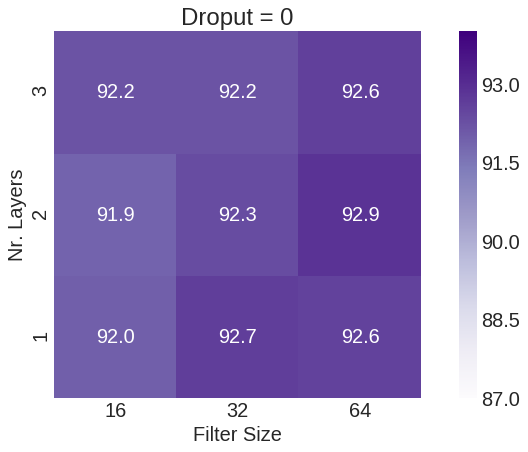

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(100*hp_matrix, ax=ax, annot=True, fmt=".1f", vmin=87, vmax=94, square=True, xticklabels=all_params["nr_neurons"], yticklabels=all_params["nr_layers"], cmap="Purples")
plt.ylim(0, 3);
plt.xlabel("Filter Size")
plt.ylabel("Nr. Layers")
plt.title("Droput = 0")
plt.tight_layout()
plt.savefig("../figs/CNN_network_size_0d.pdf", bbox_inches="tight");
hp_matrix.max()

In [91]:
hp_matrix = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        hp_matrix[i,j] = hp_df["acc_score"].iloc[(j+i*3)*2 + 1]

0.9347

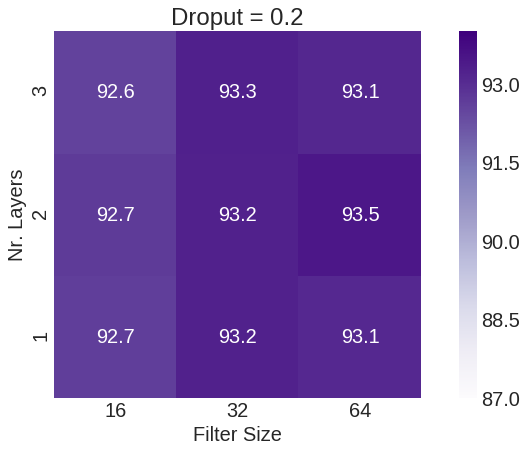

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
sns.heatmap(100*hp_matrix, ax=ax, annot=True, fmt=".1f", vmin=87, vmax=94, square=True, xticklabels=all_params["nr_neurons"], yticklabels=all_params["nr_layers"], cmap="Purples")
plt.ylim(0, 3);
plt.xlabel("Filter Size")
plt.ylabel("Nr. Layers")
plt.title("Droput = 0.2")
plt.tight_layout()
plt.savefig("../figs/CNN_network_size_20d.pdf", bbox_inches="tight");
hp_matrix.max()

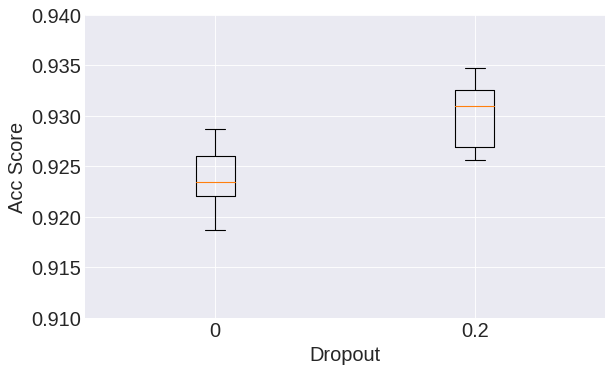

In [93]:
plt.figure(figsize=(8, 5))
asdf = [hp_df[hp_df["dropout"] == i]["acc_score"] for i in [0, 0.2]]
plt.boxplot(asdf);
plt.xlabel("Dropout")
plt.ylabel("Acc Score")
plt.xticks([1, 2], ["0", "0.2"]);
plt.ylim(0.91, 0.94)
plt.tight_layout()
plt.savefig("../figs/CNN_dropout_boxplot.pdf")